Original speech data shape: torch.Size([565, 1, 128])
Original facial data shape: torch.Size([5681, 1, 21])
Original labels shape: torch.Size([565])
Found 52 common videos between datasets
Aligned speech data shape: torch.Size([52, 1, 128])
Number of videos with aligned data: 52
Total facial frames across all videos: 5681
Average frames per video: 109.25
Min frames per video: 93
Max frames per video: 133


c:\Nini\Capstone\src\capstone_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Nini\Capstone\src\capstone_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Nini\Capstone\src\capstone_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Speech selected: 0, Facial selected: 3, Ties: 49
Speech Model Accuracy: 0.7692
Facial Model Accuracy: 0.2115
Ensemble Model Accuracy: 0.7692


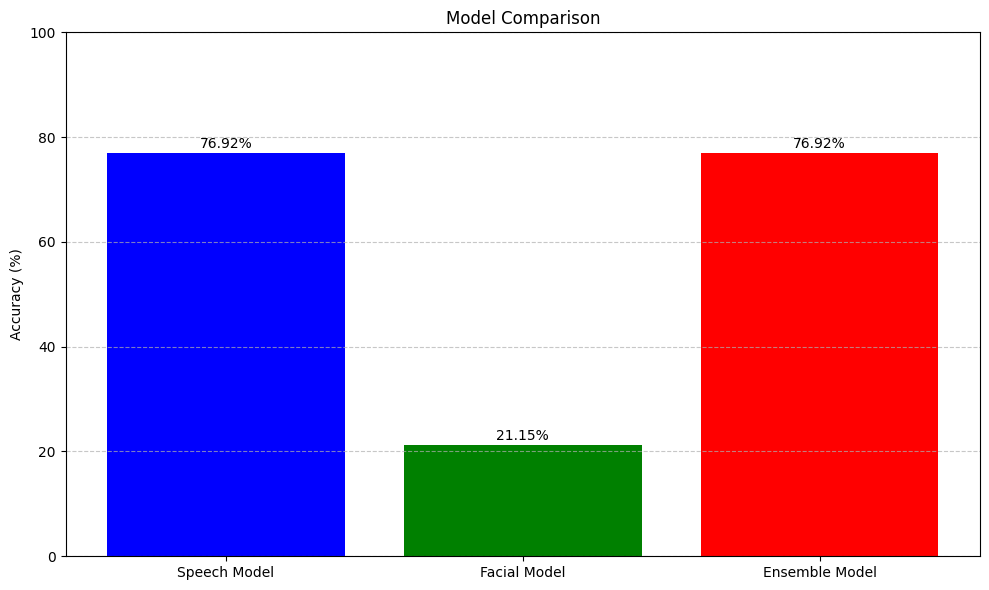

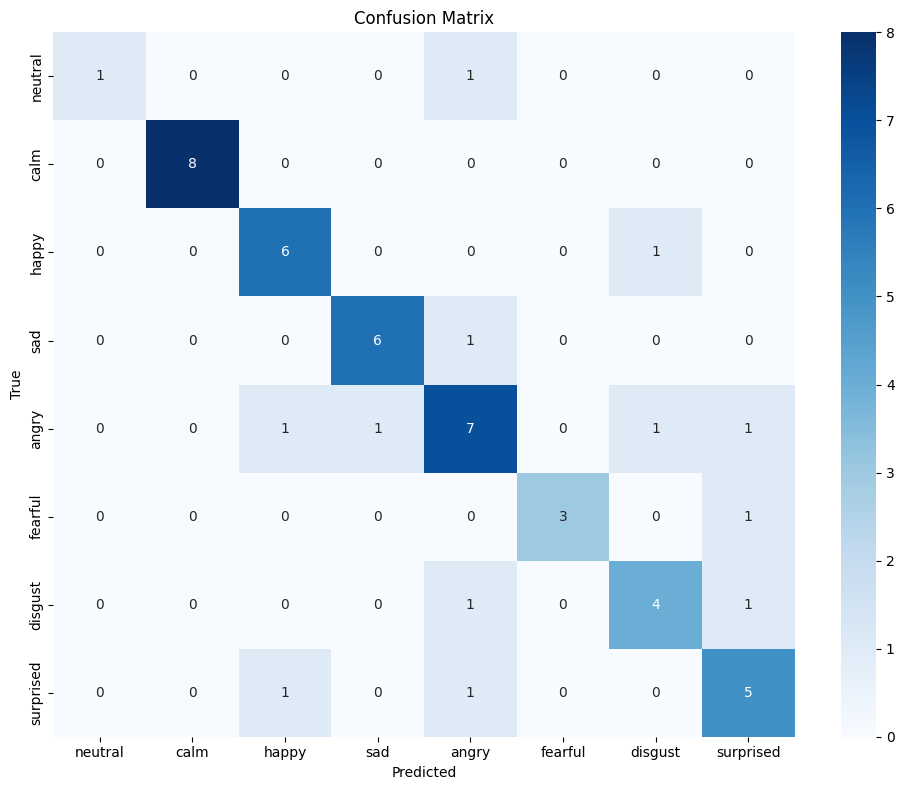


Ensemble Classification Report:
neutral: precision=1.00, recall=0.50, f1-score=0.67
calm: precision=1.00, recall=1.00, f1-score=1.00
happy: precision=0.75, recall=0.86, f1-score=0.80
sad: precision=0.86, recall=0.86, f1-score=0.86
angry: precision=0.64, recall=0.64, f1-score=0.64
fearful: precision=1.00, recall=0.75, f1-score=0.86
disgust: precision=0.67, recall=0.67, f1-score=0.67
surprised: precision=0.62, recall=0.71, f1-score=0.67
macro avg: precision=0.82, recall=0.75, f1-score=0.77
weighted avg: precision=0.78, recall=0.77, f1-score=0.77


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import os

# Keep original model definitions
class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=8)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=8)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(kernel_size=4, padding=2)
        self.dropout1 = nn.Dropout(0.5)
        self.conv3 = nn.Conv1d(128, 128, kernel_size=8)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=4, padding=2)
        self.dropout2 = nn.Dropout(0.5)
        self.conv4 = nn.Conv1d(128, 64, kernel_size=3, padding=2)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(512, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

class EmotionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=192, num_classes=8, dropout_rate=0.3):
        super(EmotionLSTM, self).__init__()
        
        # Simplified architecture - one bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Simple dense layers
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Get last time step or squeeze
        if lstm_out.size(1) == 1:
            lstm_out = lstm_out.squeeze(1)
        else:
            lstm_out = lstm_out[:, -1, :]
        
        # Apply batch normalization
        lstm_out = self.bn(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Dense layers
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
# Modified Ensemble Model
class ModifiedEnsemble(nn.Module):
    def __init__(self, speech_model, facial_model):
        super(ModifiedEnsemble, self).__init__()
        self.speech_model = speech_model
        self.facial_model = facial_model
        
        # Freeze base models (optional)
        for param in self.speech_model.parameters():
            param.requires_grad = False
        for param in self.facial_model.parameters():
            param.requires_grad = False
            
        # Learnable weights for each model
        self.speech_weight = nn.Parameter(torch.tensor(0.5))
        self.facial_weight = nn.Parameter(torch.tensor(0.5))
        
        # Threshold for MaxConfidence model
        self.confidence_margin = nn.Parameter(torch.tensor(0.05))
        
    def forward(self, speech_input, facial_frames):
        """
        Args:
            speech_input: Single speech sample tensor for a video [1, 1, feature_dim]
            facial_frames: Multiple facial frames for the same video [num_frames, 1, feature_dim]
        """
        batch_size = speech_input.shape[0]
        
        # Process speech data
        speech_out = self.speech_model(speech_input)
        speech_probs = torch.softmax(speech_out, dim=1)
        speech_max_conf, _ = speech_probs.max(dim=1)
        
        # Process all facial frames
        all_facial_probs = []
        
        for i in range(batch_size):
            video_frames = facial_frames[i]  # Get all frames for current video
            frame_probs = []
            
            # Process each frame
            for frame in video_frames:
                frame = frame.unsqueeze(0)  # Add batch dimension [1, 1, feature_dim]
                frame_out = self.facial_model(frame)
                frame_probs.append(torch.softmax(frame_out, dim=1))
            
            # Aggregate frame probabilities
            if frame_probs:
                # Stack and average frame predictions
                video_facial_probs = torch.mean(torch.cat(frame_probs, dim=0), dim=0, keepdim=True)
                all_facial_probs.append(video_facial_probs)
            else:
                # Fallback if no frames (shouldn't happen)
                dummy_probs = torch.ones(1, speech_out.shape[1], device=speech_input.device) / speech_out.shape[1]
                all_facial_probs.append(dummy_probs)
        
        # Stack all facial probabilities
        facial_probs = torch.cat(all_facial_probs, dim=0)
        facial_max_conf, _ = facial_probs.max(dim=1)
        
        # MaxConfidence selection with margin
        margin = torch.sigmoid(self.confidence_margin)  # Convert to 0-1 range
        
        # Count which model is selected (for debugging)
        with torch.no_grad():
            speech_selected = (speech_max_conf >= facial_max_conf + margin).sum().item()
            facial_selected = (facial_max_conf > speech_max_conf + margin).sum().item() 
            tie_selected = batch_size - speech_selected - facial_selected
            print(f"Speech selected: {speech_selected}, Facial selected: {facial_selected}, Ties: {tie_selected}")
        
        # Choose output based on confidence with margin
        final_probs = torch.where(
            (facial_max_conf - speech_max_conf > margin).unsqueeze(1),
            facial_probs,
            speech_probs
        )
        
        return final_probs

class ModifiedEnsemble1(nn.Module):
    def __init__(self, speech_model, facial_model, speech_weight=0.5, facial_weight=0.5):
        super(ModifiedEnsemble1, self).__init__()
        self.speech_model = speech_model
        self.facial_model = facial_model

        # Freeze base models
        for param in self.speech_model.parameters():
            param.requires_grad = False
        for param in self.facial_model.parameters():
            param.requires_grad = False

        # Fixed weights
        self.speech_weight = speech_weight
        self.facial_weight = facial_weight

    def forward(self, speech_input, facial_frames):
        batch_size = speech_input.shape[0]
        num_classes = self.speech_model(speech_input).shape[1]

        # Speech model output (logits)
        speech_out = self.speech_model(speech_input)

        all_facial_logits = []

        for i in range(batch_size):
            video_frames = facial_frames[i]
            frame_logits = []

            for frame in video_frames:
                frame = frame.unsqueeze(0)  # shape: [1, 1, feature_dim]
                frame_out = self.facial_model(frame)
                frame_logits.append(frame_out)

            if frame_logits:
                video_facial_logits = torch.mean(torch.cat(frame_logits, dim=0), dim=0, keepdim=True)
                all_facial_logits.append(video_facial_logits)
            else:
                dummy_logits = torch.zeros(1, num_classes, device=speech_input.device)
                all_facial_logits.append(dummy_logits)

        facial_out = torch.cat(all_facial_logits, dim=0)

        # Weighted fusion (static weights)
        final_logits = self.speech_weight * speech_out + self.facial_weight * facial_out
        final_probs = F.softmax(final_logits, dim=1)

        return final_probs
    
class SimpleBestModelSelector:
    def __init__(self, speech_model, facial_model, use_speech=True):
        """
        use_speech: True to use speech model, False to use facial model
        """
        self.speech_model = speech_model
        self.facial_model = facial_model
        self.use_speech = use_speech  # Set this based on evaluation results

    def predict(self, speech_input, facial_frames):
        if self.use_speech:
            with torch.no_grad():
                out = self.speech_model(speech_input)
                return torch.softmax(out, dim=1)
        else:
            batch_size = len(facial_frames)
            all_facial_logits = []

            for i in range(batch_size):
                frame_logits = []
                for frame in facial_frames[i]:
                    frame = frame.unsqueeze(0)
                    with torch.no_grad():
                        frame_out = self.facial_model(frame)
                    frame_logits.append(frame_out)

                if frame_logits:
                    video_logits = torch.mean(torch.cat(frame_logits, dim=0), dim=0, keepdim=True)
                else:
                    num_classes = self.facial_model(torch.zeros(1, 1, facial_frames[0][0].shape[-1])).shape[1]
                    video_logits = torch.zeros(1, num_classes)
                
                all_facial_logits.append(video_logits)

            facial_logits = torch.cat(all_facial_logits, dim=0)
            return torch.softmax(facial_logits, dim=1)

# Function to organize data by video
def organize_data_by_video(speech_data, facial_data, df_csv, df_excel, labels):
    """
    Organize data so that each video has one speech sample and multiple facial frames
    
    Args:
        speech_data: Tensor of speech features [num_videos, 1, feature_dim]
        facial_data: Tensor of facial features [num_frames, 1, feature_dim]
        df_csv: DataFrame containing speech data with Path column
        df_excel: DataFrame containing facial data with video_name column
        labels: Tensor of emotion labels [num_videos]
        
    Returns:
        tuple: (aligned_speech_data, aligned_facial_frames, aligned_labels, aligned_video_ids)
    """
    # Extract video IDs from speech data
    speech_video_names = df_csv['Path'].values
    speech_video_ids = [os.path.splitext(os.path.basename(f))[0] for f in speech_video_names]
    
    # Create mapping from video ID to facial frames using the video_name column directly
    video_to_frames = {}
    for i, vid_name in enumerate(df_excel['video_name']):
        # Extract just the filename without extension
        vid = os.path.splitext(os.path.basename(vid_name))[0]
        if vid not in video_to_frames:
            video_to_frames[vid] = []
        video_to_frames[vid].append(i)
    
    # Find common videos
    common_video_ids = set(speech_video_ids).intersection(set(video_to_frames.keys()))
    print(f"Found {len(common_video_ids)} common videos between datasets")
    
    if len(common_video_ids) == 0:
        print("ERROR: No common videos found between datasets!")
        # Print some examples to help debug
        print(f"Speech video IDs (first 5): {speech_video_ids[:5]}")
        print(f"Facial video IDs (first 5): {list(video_to_frames.keys())[:5]}")
        return None, None, None, None
    
    # Prepare aligned data
    aligned_speech_data = []
    aligned_facial_frames = []  # Will be a list of lists of frames
    aligned_labels = []
    aligned_video_ids = []
    
    for vid in common_video_ids:
        # Find speech sample for this video
        speech_idx = speech_video_ids.index(vid)
        speech_sample = speech_data[speech_idx]
        label = labels[speech_idx]
        
        # Get all facial frames for this video
        frame_indices = video_to_frames[vid]
        video_frames = [facial_data[i] for i in frame_indices]
        
        # Append to results
        aligned_speech_data.append(speech_sample)
        aligned_facial_frames.append(video_frames)
        aligned_labels.append(label)
        aligned_video_ids.append(vid)
    
    # Convert speech data and labels to tensors
    aligned_speech_data = torch.stack(aligned_speech_data)
    aligned_labels = torch.tensor(aligned_labels)
    
    return aligned_speech_data, aligned_facial_frames, aligned_labels, aligned_video_ids

# Function to evaluate the modified ensemble
def evaluate_modified_ensemble(model, speech_data, facial_frames_list, labels, device='cuda'):
    """
    Evaluate modified ensemble model with per-video facial frames
    
    Args:
        model: Modified ensemble model
        speech_data: Speech features tensor [num_videos, 1, feature_dim]
        facial_frames_list: List of lists of facial frames tensors
        labels: Ground truth labels tensor [num_videos]
        device: Device to run evaluation on
    
    Returns:
        dict: Evaluation metrics
    """
    model.eval()
    
    # Move speech data and labels to device
    speech_data = speech_data.to(device)
    labels = labels.to(device)
    
    # Prepare facial frames
    device_facial_frames = []
    for video_frames in facial_frames_list:
        device_frames = [frame.to(device) for frame in video_frames]
        device_facial_frames.append(device_frames)
    
    with torch.no_grad():
        # Forward pass
        outputs = model(speech_data, device_facial_frames)
        _, predicted = torch.max(outputs, 1)
        
        # Convert to numpy for sklearn metrics
        predicted_np = predicted.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # Calculate metrics
        acc = accuracy_score(labels_np, predicted_np)
        report = classification_report(labels_np, predicted_np, 
                                      target_names=EMOTION_LABELS, output_dict=True)
        conf_matrix = confusion_matrix(labels_np, predicted_np)
        
        return {
            'accuracy': acc,
            'per_class_accuracy': report['weighted avg']['precision'],
            'classification_report': report,
            'confusion_matrix': conf_matrix
        }

def evaluate_individual_models_with_frames(speech_model, facial_model, speech_data, 
                                          facial_frames_list, labels, device='cuda'):
    """
    Evaluate individual models with per-video facial frames
    
    Args:
        speech_model: Speech emotion model
        facial_model: Facial emotion model
        speech_data: Speech features tensor [num_videos, 1, feature_dim]
        facial_frames_list: List of lists of facial frames tensors
        labels: Ground truth labels tensor [num_videos]
        device: Device to run evaluation on
    
    Returns:
        dict: Dictionary with evaluation results for each model
    """
    # Move speech data and labels to device
    speech_data = speech_data.to(device)
    labels = labels.to(device)
    
    # Set models to evaluation mode
    speech_model.eval()
    facial_model.eval()
    
    with torch.no_grad():
        # Speech model predictions
        speech_outputs = speech_model(speech_data)
        _, speech_preds = torch.max(speech_outputs, 1)
        
        # Facial model predictions
        facial_preds_list = []
        for i, video_frames in enumerate(facial_frames_list):
            frame_preds = []
            for frame in video_frames:
                frame = frame.to(device)
                frame_out = facial_model(frame.unsqueeze(0))
                _, frame_pred = torch.max(frame_out, 1)
                frame_preds.append(frame_pred.item())
            
            # Majority voting for video prediction
            if frame_preds:
                video_pred = max(set(frame_preds), key=frame_preds.count)
                facial_preds_list.append(video_pred)
            else:
                # Fallback (shouldn't happen)
                facial_preds_list.append(0)
        
        facial_preds = torch.tensor(facial_preds_list, device=device)
        
        # Convert to numpy
        speech_preds_np = speech_preds.cpu().numpy()
        facial_preds_np = facial_preds.cpu().numpy()
        labels_np = labels.cpu().numpy()
        
        # Calculate accuracies
        speech_acc = accuracy_score(labels_np, speech_preds_np)
        facial_acc = accuracy_score(labels_np, facial_preds_np)
        
        # Generate reports
        speech_report = classification_report(labels_np, speech_preds_np, 
                                             target_names=EMOTION_LABELS, output_dict=True)
        facial_report = classification_report(labels_np, facial_preds_np, 
                                             target_names=EMOTION_LABELS, output_dict=True)
        
        # Generate confusion matrices
        speech_cm = confusion_matrix(labels_np, speech_preds_np)
        facial_cm = confusion_matrix(labels_np, facial_preds_np)
        
        return {
            'speech': {
                'accuracy': speech_acc,
                'classification_report': speech_report,
                'confusion_matrix': speech_cm
            },
            'facial': {
                'accuracy': facial_acc,
                'classification_report': facial_report,
                'confusion_matrix': facial_cm
            }
        }

def plot_comparison(results):
    """
    Plot comparison of models
    
    Args:
        results: Results dictionary from evaluate_individual_vs_ensemble
    """
    models = ['Speech Model', 'Facial Model', 'Ensemble Model']
    accuracies = [
        results['speech']['accuracy'] * 100,
        results['facial']['accuracy'] * 100,
        results['ensemble']['accuracy'] * 100
    ]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['blue', 'green', 'red'])
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.ylabel('Accuracy (%)')
    plt.title('Model Comparison')
    plt.ylim(0, 100)  # Set y-axis from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

def visualize_confusion_matrix(conf_matrix, class_names=EMOTION_LABELS):
    """
    Visualize confusion matrix
    
    Args:
        conf_matrix: Confusion matrix
        class_names: List of class names
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def main():
    # Load your models and data here
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set constants
    global EMOTION_LABELS  # Make sure this is accessible to all functions
    NUM_EMOTIONS = 8  # For RAVDESS dataset
    EMOTION_LABELS = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
    
    # For data loading - using your existing paths
    df_csv = pd.read_csv("C:/Nini/Capstone/CSV_Files/Speech data/Speech_Test_preprocessed_new.csv")
    df_excel = pd.read_excel("C:/Nini/Capstone/CSV_Files/Facial data/FacialFeatures_Test.xlsx")
    
    # Extract features and labels
    X_train_speech = df_csv.drop(['Unnamed: 0','Path','Emotion'], axis=1).to_numpy()  
    X_train_face = df_excel.drop(['Unnamed: 0','emotion','video_name','BaseName'], axis=1).to_numpy()
    
    # Convert to tensors
    speech_test_data = torch.tensor(X_train_speech, dtype=torch.float32).unsqueeze(1)
    facial_test_data = torch.tensor(X_train_face, dtype=torch.float32).unsqueeze(1)
    
    # Get label encoder and encode labels
    lb = joblib.load("C:/Nini/Capstone/src/Model_training/label_encoder.pkl")
    raw_labels = df_csv['Emotion']
    encoded_labels = lb.transform(raw_labels)
    test_labels = torch.tensor(encoded_labels)
    
    # Print original data shapes
    print(f"Original speech data shape: {speech_test_data.shape}")
    print(f"Original facial data shape: {facial_test_data.shape}")
    print(f"Original labels shape: {test_labels.shape}")
    
    # Organize data by video - passing the dataframes directly
    aligned_speech_data, aligned_facial_frames, aligned_labels, aligned_video_ids = organize_data_by_video(
        speech_test_data, facial_test_data, df_csv, df_excel, test_labels
    )
    
    if aligned_speech_data is None:
        print("Exiting due to data alignment failure")
        return
    
    # Print aligned data info
    print(f"Aligned speech data shape: {aligned_speech_data.shape}")
    print(f"Number of videos with aligned data: {len(aligned_facial_frames)}")
    print(f"Total facial frames across all videos: {sum(len(frames) for frames in aligned_facial_frames)}")
    print(f"Average frames per video: {sum(len(frames) for frames in aligned_facial_frames) / len(aligned_facial_frames):.2f}")
    
    # Print frame distribution to understand data better
    frame_counts = [len(frames) for frames in aligned_facial_frames]
    print(f"Min frames per video: {min(frame_counts)}")
    print(f"Max frames per video: {max(frame_counts)}")
    
    # Initialize models
    speech_model = CNNModel(input_size=X_train_speech.shape[1], num_classes=NUM_EMOTIONS).to(device)
    facial_model = EmotionLSTM(input_size=X_train_face.shape[1], num_classes=NUM_EMOTIONS).to(device)
    
    # Load pre-trained weights
    speech_model.load_state_dict(torch.load('C:/Nini/Capstone/Models/DataAugmentation_cnn_model_new_final.pth', 
                                         weights_only=True))
    facial_model.load_state_dict(torch.load('C:/Nini/Capstone/src/Facial Models/emotion_lstm_model.pth', 
                                         weights_only=True))
    
    # Create modified ensemble model
    ensemble_model = ModifiedEnsemble(speech_model, facial_model).to(device)
    
    # Evaluate individual models
    individual_results = evaluate_individual_models_with_frames(
        speech_model, facial_model, aligned_speech_data, aligned_facial_frames, aligned_labels, device
    )

    # Evaluate ensemble model
    ensemble_results = evaluate_modified_ensemble(
        ensemble_model, aligned_speech_data, aligned_facial_frames, aligned_labels, device
    )
    
    # Combine results
    all_results = {
        'speech': individual_results['speech'],
        'facial': individual_results['facial'],
        'ensemble': ensemble_results
    }
    
    # Print results
    print(f"Speech Model Accuracy: {all_results['speech']['accuracy']:.4f}")
    print(f"Facial Model Accuracy: {all_results['facial']['accuracy']:.4f}")
    print(f"Ensemble Model Accuracy: {all_results['ensemble']['accuracy']:.4f}")
    
    # Plot comparison
    plot_comparison(all_results)
    
    # Visualize confusion matrix for the ensemble
    visualize_confusion_matrix(all_results['ensemble']['confusion_matrix'])
    
    # Print detailed report for ensemble
    print("\nEnsemble Classification Report:")
    for emotion, metrics in all_results['ensemble']['classification_report'].items():
        if isinstance(metrics, dict):
            print(f"{emotion}: precision={metrics['precision']:.2f}, " + 
                  f"recall={metrics['recall']:.2f}, f1-score={metrics['f1-score']:.2f}")

if __name__ == "__main__":
    main()